
## Caline Uwingabire
## Model: Recurrent Neural Network

In [3]:
# CELL 1: IMPORT ALL LIBRARIES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import warnings
warnings.filterwarnings('ignore')

# Install gensim
!pip install gensim

# Deep Learning Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

# NLP Libraries (
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Word Embeddings
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

# Initialize NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added to fix LookupError: Resource punkt_tab not found.


np.random.seed(42)
tf.random.set_seed(42)

print(" All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Gensim version: {gensim.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 57.0 MB/s eta 0:00:00
 All libraries imported successfully!
TensorFlow version: 2.19.0
Gensim version: 4.4.0


Data Loading

In [4]:
# Load your specific CSV files
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('val_df.csv')
test_df = pd.read_csv('test_df.csv')

# Remove empty rows to prevent errors
train_df = train_df.dropna(subset=['text'])
val_df = val_df.dropna(subset=['text'])
test_df = test_df.dropna(subset=['text'])

print(f"Dataset Loaded: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

Dataset Loaded: 31232 train, 5205 val, 5205 test.


## Phase 1: Exploratory Data Analysis (EDA)

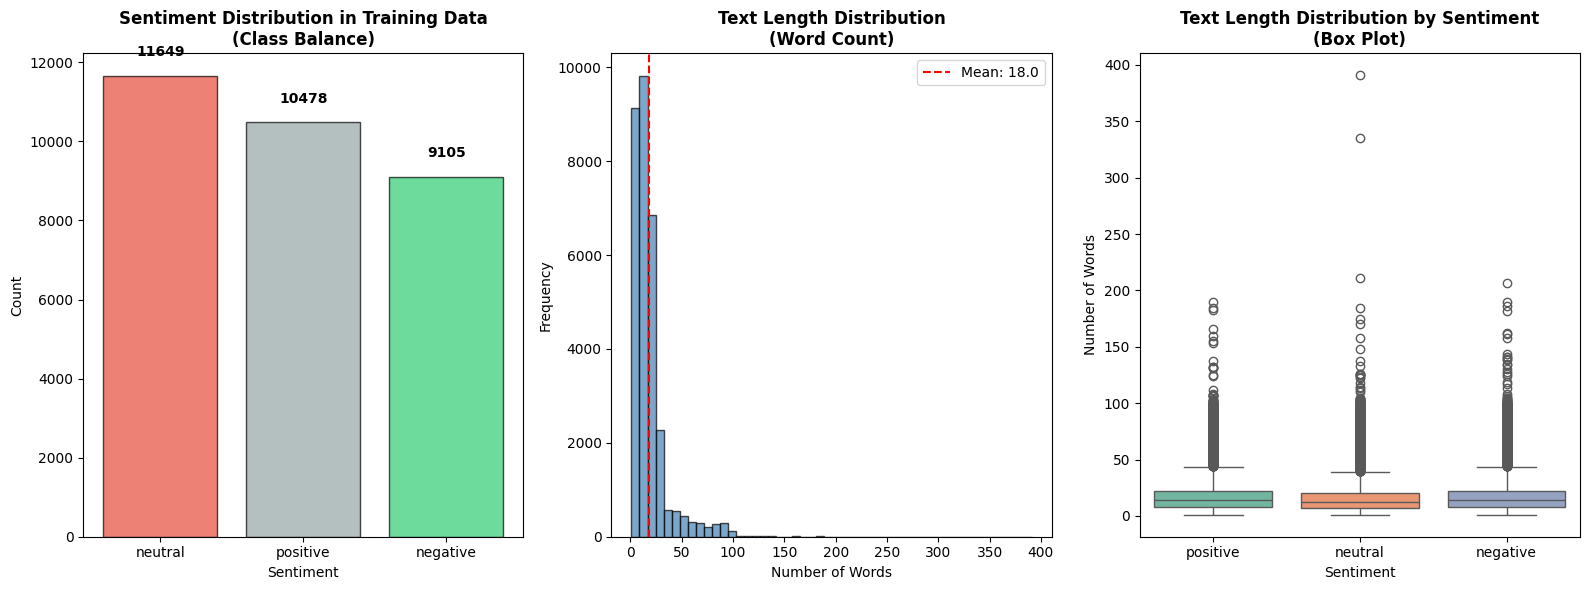

Text Length Statistics:
   - Mean: 18.03 words
   - Median: 13.00 words
   - Max: 391 words
   - Min: 1 words


In [ ]:
# CELL 2: EDA - VISUALIZATION 1, 2, & 3
# ============================================

plt.figure(figsize=(16, 6))

# 1. Class Balance Distribution
plt.subplot(1, 3, 1)
sentiment_counts = train_df['sentiment'].value_counts()
colors = ['#e74c3c', '#95a5a6', '#2ecc71']
plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors, alpha=0.7, edgecolor='black')
plt.title('Sentiment Distribution in Training Data\n(Class Balance)', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')

# 2. Text Length Distribution
plt.subplot(1, 3, 2)
train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))
plt.hist(train_df['text_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.title('Text Length Distribution\n(Word Count)', fontsize=12, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(train_df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["text_length"].mean():.1f}')
plt.legend()

# 3. Box Plot of Text Length by Sentiment
plt.subplot(1, 3, 3)
sns.boxplot(data=train_df, x='sentiment', y='text_length', palette='Set2')
plt.title('Text Length Distribution by Sentiment\n(Box Plot)', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')

plt.tight_layout()
plt.show()

print(f"Text Length Statistics:")
print(f"   - Mean: {train_df['text_length'].mean():.2f} words")
print(f"   - Median: {train_df['text_length'].median():.2f} words")
print(f"   - Max: {train_df['text_length'].max()} words")
print(f"   - Min: {train_df['text_length'].min()} words")

## Phase 2: Text Preprocessing


In [5]:
# CELL 3: TEXT PREPROCESSING
# ===================================

class TextPreprocessor:
    """
    Preprocess text for different embedding methods
    MUST be consistent across all team members for fair comparison
    """

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text, for_word2vec=True):
        """
        Clean and preprocess text
        for_word2vec=True: Returns tokenized list of words
        for_word2vec=False: Returns cleaned string for TF-IDF
        """
        if not isinstance(text, str):
            return "" if not for_word2vec else []

        # 1. Convert to lowercase
        text = text.lower()

        # 2. Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # 3. Tokenize
        tokens = word_tokenize(text)

        # 4. Remove stopwords and short words
        tokens = [word for word in tokens if word not in self.stop_words and len(word) > 2]

        # 5. Lemmatize
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        if for_word2vec:
            return tokens
        else:
            return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing
print(" Preprocessing training data...")
train_df['cleaned_text_str'] = train_df['text'].apply(lambda x: preprocessor.clean_text(x, for_word2vec=False))
train_df['cleaned_text_tokens'] = train_df['text'].apply(lambda x: preprocessor.clean_text(x, for_word2vec=True))

print("Preprocessing validation data...")
val_df['cleaned_text_str'] = val_df['text'].apply(lambda x: preprocessor.clean_text(x, for_word2vec=False))
val_df['cleaned_text_tokens'] = val_df['text'].apply(lambda x: preprocessor.clean_text(x, for_word2vec=True))

print("Preprocessing test data...")
test_df['cleaned_text_str'] = test_df['text'].apply(lambda x: preprocessor.clean_text(x, for_word2vec=False))
test_df['cleaned_text_tokens'] = test_df['text'].apply(lambda x: preprocessor.clean_text(x, for_word2vec=True))

print("Preprocessing complete!")
print(f"\n Eg transformation:")
print(f"Original: {train_df['text'].iloc[0]}")
print(f"Cleaned:  {train_df['cleaned_text_str'].iloc[0]}")

 Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...
Preprocessing complete!

 Eg transformation:
Original: Cooking microwave pizzas, yummy
Cleaned:  cooking microwave pizza yummy


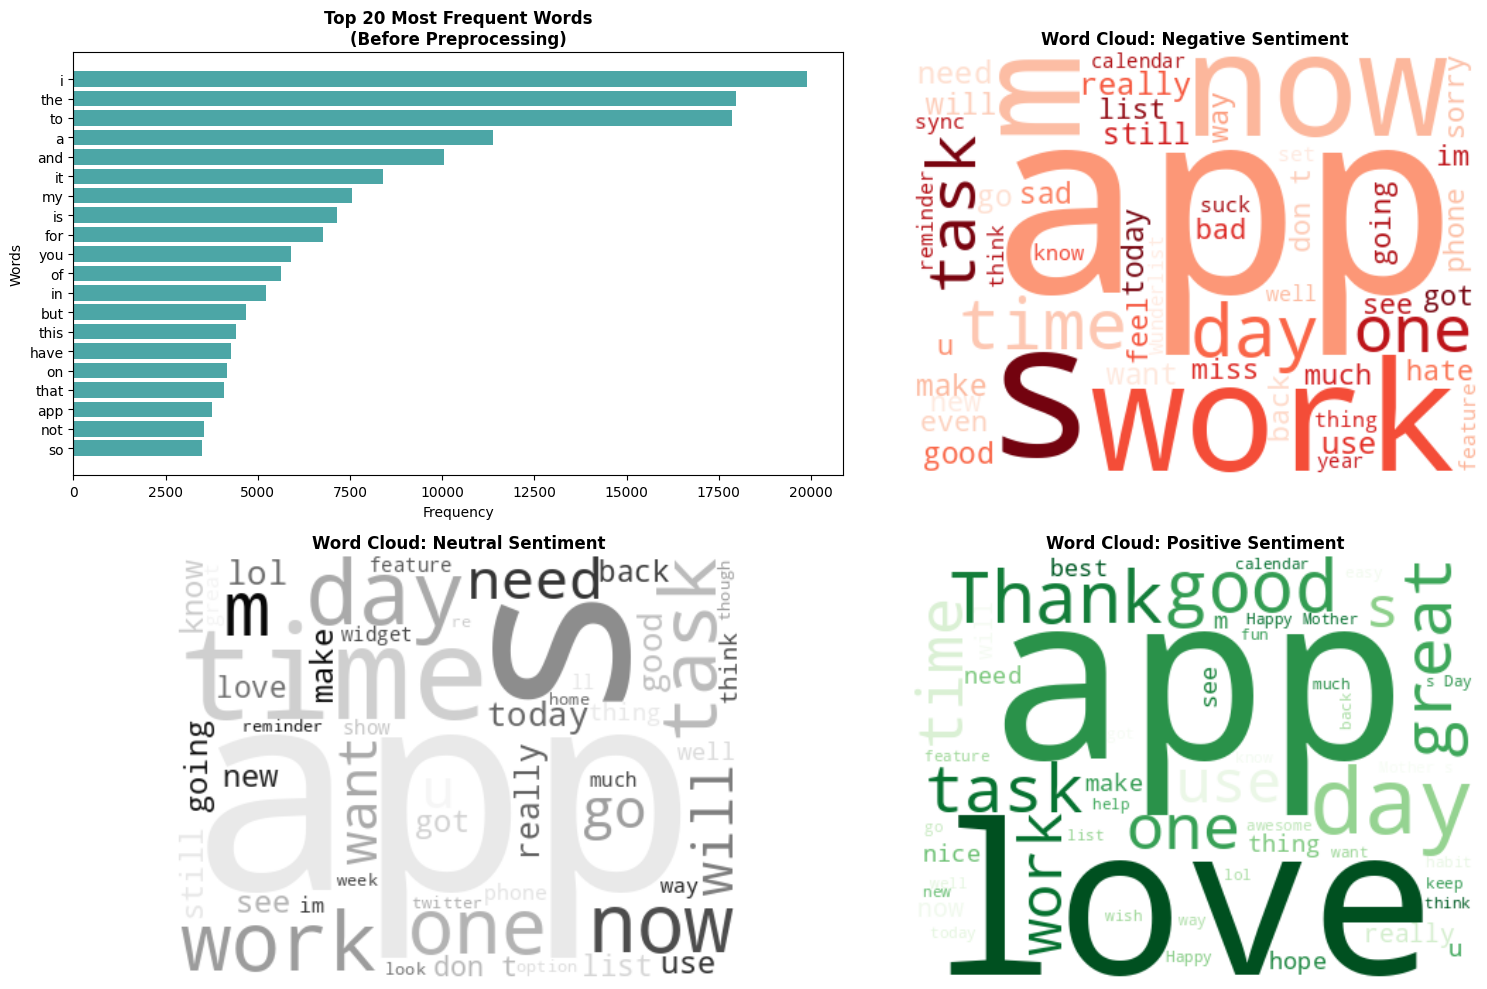

EDA complete with 5 visualizations!


In [6]:
# CELL 4: EDA - VISUALIZATION 4 (Word Clouds & Top Words)
# ============================================

from collections import Counter
from wordcloud import WordCloud

plt.figure(figsize=(16, 10))

# 4. Top 20 Most Common Words
all_words = ' '.join(train_df['text'].astype(str)).lower().split()
word_freq = Counter(all_words).most_common(20)
words, counts = zip(*word_freq)

plt.subplot(2, 2, 1)
plt.barh(words, counts, color='teal', alpha=0.7)
plt.gca().invert_yaxis()
plt.title('Top 20 Most Frequent Words\n(Before Preprocessing)', fontsize=12, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('Words')

# 5. Word Clouds by Sentiment
sentiments = ['negative', 'neutral', 'positive']
colors_wc = ['Reds', 'Greys', 'Greens']

for idx, (sentiment, cmap) in enumerate(zip(sentiments, colors_wc), start=2):
    plt.subplot(2, 2, idx)
    text_data = ' '.join(train_df[train_df['sentiment'] == sentiment]['text'].astype(str))
    wordcloud = WordCloud(width=400, height=300, background_color='white',
                          colormap=cmap, max_words=50).generate(text_data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud: {sentiment.capitalize()} Sentiment', fontsize=12, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("EDA complete with 5 visualizations!")

---
# EXPERIMENT 1: RNN with Word2Vec (Skip-gram)


In [9]:
# CELL 5: SEQUENCE PREPARATION & WORD2VEC - EXPERIMENT 1A
# ============================================

print("=" * 70)
print("EXPERIMENT 1A: RNN + Word2Vec (Skip-gram) ")
print("=" * 70)

# Hyperparameters
MAX_VOCAB = 10000
MAX_SEQUENCE_LEN = 100
EMBEDDING_DIM = 100

# Tokenize text for sequence models
print("\n Tokenizing text for RNN...")
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text_str'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['cleaned_text_str'])
X_val = tokenizer.texts_to_sequences(val_df['cleaned_text_str'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_text_str'])

# Pad sequences
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LEN, padding='post')
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LEN, padding='post')
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LEN, padding='post')

# Prepare labels
y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print(f"Sequence preparation complete!")
print(f"   - Vocabulary size: {len(tokenizer.word_index)}")
print(f"   - Training sequences shape: {X_train.shape}")

# Train Word2Vec Skip-gram model
print("\n Training Word2Vec Skip-gram model...")
sentences = train_df['cleaned_text_tokens'].tolist()
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    sg=1,  # 1 = Skip-gram
    workers=4,
    epochs=10,
    seed=42
)

print(f"Word2Vec model trained!")
print(f"   - Vocabulary size: {len(w2v_model.wv)}")

# Create embedding matrix
print("\n Creating embedding matrix...")
embedding_matrix_w2v = np.zeros((MAX_VOCAB, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB and word in w2v_model.wv:
        embedding_matrix_w2v[i] = w2v_model.wv[word]

words_covered = sum([1 for word, i in tokenizer.word_index.items() if i < MAX_VOCAB and word in w2v_model.wv])
coverage = (words_covered / min(len(tokenizer.word_index), MAX_VOCAB)) * 100
print(f" Embedding matrix created! Coverage: {coverage:.2f}%")

EXPERIMENT 1A: RNN + Word2Vec (Skip-gram) 

 Tokenizing text for RNN...
Sequence preparation complete!
   - Vocabulary size: 27802
   - Training sequences shape: (31232, 100)

 Training Word2Vec Skip-gram model...
Word2Vec model trained!
   - Vocabulary size: 10194

 Creating embedding matrix...
 Embedding matrix created! Coverage: 99.98%


---
# EXPERIMENT 2: RNN with GloVe Embeddings


### Experiment 3B: TF-IDF

In [11]:
# CELL 6: BUILD RNN MODEL FUNCTION & TRAIN EXPERIMENT 1A
# ============================================

def build_rnn_model(embedding_matrix, units=64, dropout=0.2, trainable_embedding=False, name="RNN"):
    """
    Build Simple RNN model with configurable parameters
    """
    model = Sequential([
        Embedding(MAX_VOCAB, EMBEDDING_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LEN, trainable=trainable_embedding, name='embedding'),
        SpatialDropout1D(dropout),
        SimpleRNN(units, dropout=dropout, recurrent_dropout=dropout, name='rnn'),
        Dense(32, activation='relu', name='dense_1'),
        Dropout(0.5),
        Dense(3, activation='softmax', name='output')
    ], name=name)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define callbacks here so they are available for all experiments
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Create model for Experiment 1A
model_w2v_exp1 = build_rnn_model(embedding_matrix_w2v, units=64, dropout=0.2,
                                  trainable_embedding=False, name="RNN_Word2Vec_Exp1A")

print("\n Model Architecture:")
model_w2v_exp1.summary()

# Train model
print("\nTraining RNN + Word2Vec (Experiment 1A)...")

history_w2v_exp1 = model_w2v_exp1.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("Experiment 1A training complete!")


 Model Architecture:


Model: "RNN_Word2Vec_Exp1A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (SimpleRNN)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)


Training RNN + Word2Vec (Experiment 1A)...
Epoch 1/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.3416 - loss: 1.1477 - val_accuracy: 0.3704 - val_loss: 1.0944 - learning_rate: 0.0010
Epoch 2/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.3707 - loss: 1.0942 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 3/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.3707 - loss: 1.0934 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 4/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.3714 - loss: 1.0933 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 5/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.3716 - loss: 1.0933 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 5.0000e-04
Epoch 6/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.3718 - loss: 1.0932 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 5.0000e-04
Epoch 7/15
488/488 ━━━━━

### Evaluate Experiment 1A

\ Evaluating Experiment 1A on Test Set...

EXPERIMENT 1A RESULTS: RNN + Word2Vec (64 units, frozen)
Test Accuracy:  0.3706
Test F1-Score:  0.2004
Test Precision: 0.1373
Test Recall:    0.3706

 Classification Report:
              precision    recall  f1-score   support

    Negative     0.0000    0.0000    0.0000      1546
     Neutral     0.3706    1.0000    0.5408      1929
    Positive     0.0000    0.0000    0.0000      1730

    accuracy                         0.3706      5205
   macro avg     0.1235    0.3333    0.1803      5205
weighted avg     0.1373    0.3706    0.2004      5205



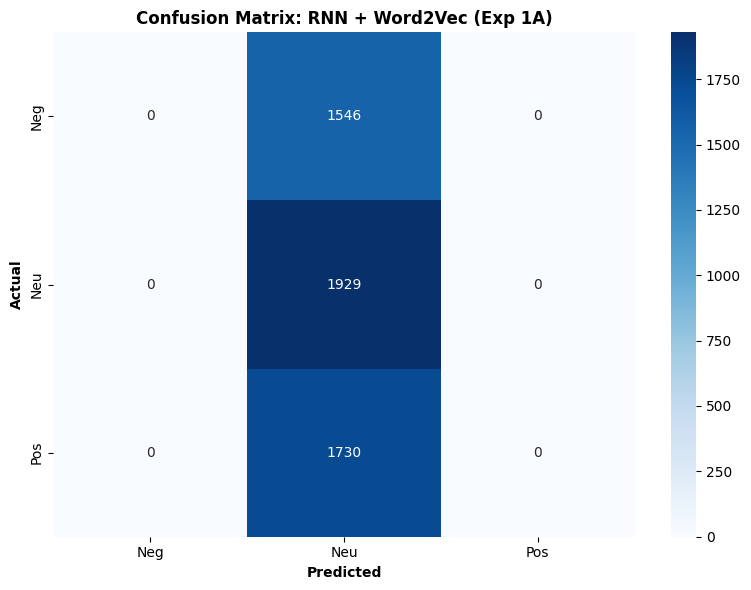

In [15]:
# CELL 7: EVALUATE EXPERIMENT 1A
# ============================================

# Evaluate on test set
print("\ Evaluating Experiment 1A on Test Set...")
y_pred_w2v_exp1 = np.argmax(model_w2v_exp1.predict(X_test, verbose=0), axis=1)

# Calculate metrics
acc_w2v_exp1 = accuracy_score(y_test, y_pred_w2v_exp1)
f1_w2v_exp1 = f1_score(y_test, y_pred_w2v_exp1, average='weighted')
precision_w2v_exp1 = precision_score(y_test, y_pred_w2v_exp1, average='weighted')
recall_w2v_exp1 = recall_score(y_test, y_pred_w2v_exp1, average='weighted')

print("\n" + "=" * 70)
print("EXPERIMENT 1A RESULTS: RNN + Word2Vec (64 units, frozen)")
print("=" * 70)
print(f"Test Accuracy:  {acc_w2v_exp1:.4f}")
print(f"Test F1-Score:  {f1_w2v_exp1:.4f}")
print(f"Test Precision: {precision_w2v_exp1:.4f}")
print(f"Test Recall:    {recall_w2v_exp1:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_w2v_exp1,
                          target_names=['Negative', 'Neutral', 'Positive'], digits=4))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_w2v_exp1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.title('Confusion Matrix: RNN + Word2Vec (Exp 1A)', fontweight='bold')
plt.tight_layout()
plt.show()


EXPERIMENT 1B: RNN + Word2Vec 

 Training...
Epoch 1/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.3342 - loss: 1.2047 - val_accuracy: 0.3704 - val_loss: 1.0927 - learning_rate: 0.0010
Epoch 2/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.3677 - loss: 1.1001 - val_accuracy: 0.3902 - val_loss: 1.0903 - learning_rate: 0.0010
Epoch 3/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.3755 - loss: 1.0958 - val_accuracy: 0.3704 - val_loss: 1.0903 - learning_rate: 0.0010
Epoch 4/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.3705 - loss: 1.0934 - val_accuracy: 0.3704 - val_loss: 1.0924 - learning_rate: 0.0010
Epoch 5/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.3682 - loss: 1.0933 - val_accuracy: 0.3704 - val_loss: 1.0940 - learning_rate: 5.0000e-04
Epoch 6/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.3659 - loss: 1.0946 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 5.0000e-04

EXPERIMENT 1B RESULTS

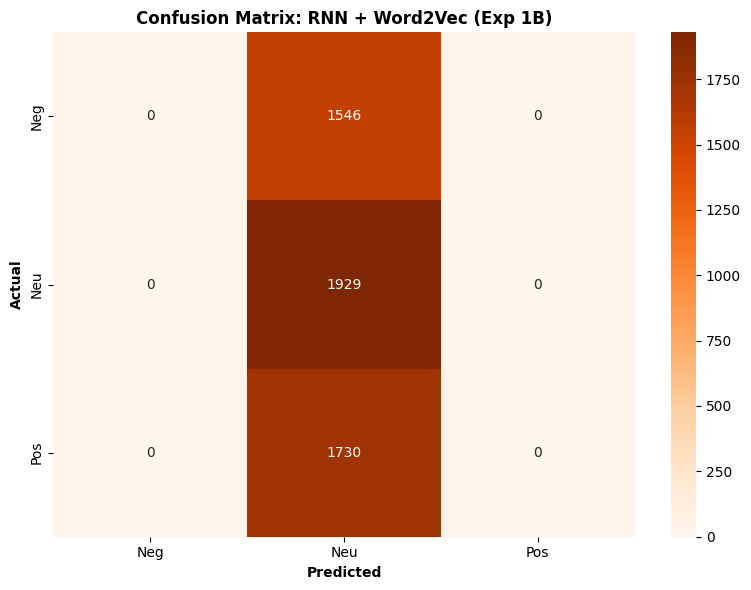

Experiment 1B complete!


In [16]:
# CELL 8: WORD2VEC EXPERIMENT 1B - HYPERPARAMETER TUNING
# ============================================

print("\n" + "=" * 70)
print("EXPERIMENT 1B: RNN + Word2Vec ")
print("=" * 70)

model_w2v_exp2 = build_rnn_model(embedding_matrix_w2v, units=128, dropout=0.3,
                                  trainable_embedding=True, name="RNN_Word2Vec_Exp1B")

print("\n Training...")
history_w2v_exp2 = model_w2v_exp2.fit(
    X_train, y_train, epochs=15, batch_size=64,
    validation_data=(X_val, y_val), callbacks=[early_stop, reduce_lr], verbose=1
)

# Evaluate
y_pred_w2v_exp2 = np.argmax(model_w2v_exp2.predict(X_test, verbose=0), axis=1)
acc_w2v_exp2 = accuracy_score(y_test, y_pred_w2v_exp2)
f1_w2v_exp2 = f1_score(y_test, y_pred_w2v_exp2, average='weighted')
precision_w2v_exp2 = precision_score(y_test, y_pred_w2v_exp2, average='weighted')
recall_w2v_exp2 = recall_score(y_test, y_pred_w2v_exp2, average='weighted')

print("\n" + "=" * 70)
print("EXPERIMENT 1B RESULTS")
print("=" * 70)
print(f"Test Accuracy:  {acc_w2v_exp2:.4f}")
print(f"Test F1-Score:  {f1_w2v_exp2:.4f}")
print(f" Improvement: {(acc_w2v_exp2 - acc_w2v_exp1) * 100:+.2f}% accuracy")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_w2v_exp2,
                          target_names=['Negative', 'Neutral', 'Positive'], digits=4))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_w2v_exp2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.title('Confusion Matrix: RNN + Word2Vec (Exp 1B)', fontweight='bold')
plt.tight_layout()
plt.show()

print("Experiment 1B complete!")

In [ ]:
# CELL 9: GLOVE EMBEDDING - EXPERIMENT 2A
# ============================================

print("=" * 70)
print("EXPERIMENT 2A: RNN + GloVe ")
print("=" * 70)

print("\n Loading GloVe embeddings...")
try:
    glove_vectors = api.load('glove-wiki-gigaword-100')
    print(f" Loaded GloVe! Vocabulary: {len(glove_vectors)}")

    embedding_matrix_glove = np.zeros((MAX_VOCAB, EMBEDDING_DIM))
    for word, i in tokenizer.word_index.items():
        if i < MAX_VOCAB and word in glove_vectors:
            embedding_matrix_glove[i] = glove_vectors[word]

    words_covered = sum([1 for word, i in tokenizer.word_index.items() if i < MAX_VOCAB and word in glove_vectors])
    coverage = (words_covered / min(len(tokenizer.word_index), MAX_VOCAB)) * 100
    print(f"Embedding matrix created! Coverage: {coverage:.2f}%")

except Exception as e:
    print(f" Could not load via gensim: {e}")
    print("Loading from local file...")

    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f" Loaded {len(embeddings_index)} vectors from local file")

    embedding_matrix_glove = np.zeros((MAX_VOCAB, EMBEDDING_DIM))
    words_covered = 0
    for word, i in tokenizer.word_index.items():
        if i < MAX_VOCAB:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix_glove[i] = embedding_vector
                words_covered += 1

    coverage = (words_covered / min(len(tokenizer.word_index), MAX_VOCAB)) * 100
    print(f"Embedding matrix created! Coverage: {coverage:.2f}%")

# Build and train
model_glove_exp1 = build_rnn_model(embedding_matrix_glove, units=64, dropout=0.2,
                                    trainable_embedding=False, name="RNN_GloVe_Exp2A")

print("\n Training RNN + GloVe (Experiment 2A)...")
history_glove_exp1 = model_glove_exp1.fit(
    X_train, y_train, epochs=15, batch_size=64,
    validation_data=(X_val, y_val), callbacks=[early_stop, reduce_lr], verbose=1
)

# Evaluate
y_pred_glove_exp1 = np.argmax(model_glove_exp1.predict(X_test, verbose=0), axis=1)
acc_glove_exp1 = accuracy_score(y_test, y_pred_glove_exp1)
f1_glove_exp1 = f1_score(y_test, y_pred_glove_exp1, average='weighted')
precision_glove_exp1 = precision_score(y_test, y_pred_glove_exp1, average='weighted')
recall_glove_exp1 = recall_score(y_test, y_pred_glove_exp1, average='weighted')

print("\n" + "=" * 70)
print("EXPERIMENT 2A RESULTS: RNN + GloVe")
print("=" * 70)
print(f"Test Accuracy:  {acc_glove_exp1:.4f}")
print(f"Test F1-Score:  {f1_glove_exp1:.4f}")
print(f"Test Precision: {precision_glove_exp1:.4f}")
print(f"Test Recall:    {recall_glove_exp1:.4f}")
print(" Experiment 2A complete!")

EXPERIMENT 2A: RNN + GloVe 

 Loading GloVe embeddings...
 Loaded GloVe! Vocabulary: 400000
Embedding matrix created! Coverage: 90.51%

 Training RNN + GloVe (Experiment 2A)...
Epoch 1/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.3444 - loss: 1.1410 - val_accuracy: 0.3704 - val_loss: 1.0944 - learning_rate: 0.0010
Epoch 2/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.3634 - loss: 1.0952 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 3/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.3708 - loss: 1.0937 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 4/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.3702 - loss: 1.0935 - val_accuracy: 0.3704 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 5/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.3717 - loss: 1.0935 - val_accuracy: 0.3704 - val_loss: 1.0940 - learning_rate: 5.0000e-04

EXPERIMENT 2A RESULTS: RNN + GloVe
Test Accuracy

In [ ]:
# CELL 10: GLOVE EXPERIMENT 2B
# ============================================

print("\n" + "=" * 70)
print("EXPERIMENT 2B: RNN + GloVe ")
print("=" * 70)

model_glove_exp2 = build_rnn_model(embedding_matrix_glove, units=64, dropout=0.3,
                                    trainable_embedding=True, name="RNN_GloVe_Exp2B")

print("\n Training...")
history_glove_exp2 = model_glove_exp2.fit(
    X_train, y_train, epochs=15, batch_size=64,
    validation_data=(X_val, y_val), callbacks=[early_stop, reduce_lr], verbose=1
)

# Evaluate
y_pred_glove_exp2 = np.argmax(model_glove_exp2.predict(X_test, verbose=0), axis=1)
acc_glove_exp2 = accuracy_score(y_test, y_pred_glove_exp2)
f1_glove_exp2 = f1_score(y_test, y_pred_glove_exp2, average='weighted')
precision_glove_exp2 = precision_score(y_test, y_pred_glove_exp2, average='weighted')
recall_glove_exp2 = recall_score(y_test, y_pred_glove_exp2, average='weighted')

print("\n" + "=" * 70)
print("EXPERIMENT 2B RESULTS")
print("=" * 70)
print(f"Test Accuracy:  {acc_glove_exp2:.4f}")
print(f"Test F1-Score:  {f1_glove_exp2:.4f}")
print(f" Improvement: {(acc_glove_exp2 - acc_glove_exp1) * 100:+.2f}% accuracy")
print(" Experiment 2B complete!")


EXPERIMENT 2B: RNN + GloVe 

 Training...
Epoch 1/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3398 - loss: 1.1599 - val_accuracy: 0.3664 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 2/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3533 - loss: 1.1038 - val_accuracy: 0.3704 - val_loss: 1.0952 - learning_rate: 0.0010
Epoch 3/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3645 - loss: 1.0962 - val_accuracy: 0.3704 - val_loss: 1.0945 - learning_rate: 0.0010
Epoch 4/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.3676 - loss: 1.0939 - val_accuracy: 0.3704 - val_loss: 1.0940 - learning_rate: 0.0010
Epoch 5/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3665 - loss: 1.0947 - val_accuracy: 0.3704 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 6/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3728 - loss: 1.0936 - val_accuracy: 0.3704 - val_loss: 1.0940 - learning_rate: 0.0010
Epoch 7/15
488/488 ━━━━━━━━━━━━━━

EXPERIMENT 3A: RNN + TF-IDF

 Generating TF-IDF features...
TF-IDF complete! Feature dimension: 5000

Training RNN + TF-IDF (Experiment 3A)...
Epoch 1/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4940 - loss: 0.9913 - val_accuracy: 0.6565 - val_loss: 0.7746 - learning_rate: 0.0010
Epoch 2/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6527 - loss: 0.7969 - val_accuracy: 0.6644 - val_loss: 0.7626 - learning_rate: 0.0010
Epoch 3/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6806 - loss: 0.7552 - val_accuracy: 0.6553 - val_loss: 0.7660 - learning_rate: 0.0010
Epoch 4/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6937 - loss: 0.7258 - val_accuracy: 0.6571 - val_loss: 0.7777 - learning_rate: 0.0010
Epoch 5/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7008 - loss: 0.7026 - val_accuracy: 0.6486 - val_loss: 0.7856 - learning_rate: 5.0000e-04

EXPERIMENT 3A RESULTS: RNN + TF-IDF
Test Accuracy:  0.6634
Test F1-Score:  0.6649
Test

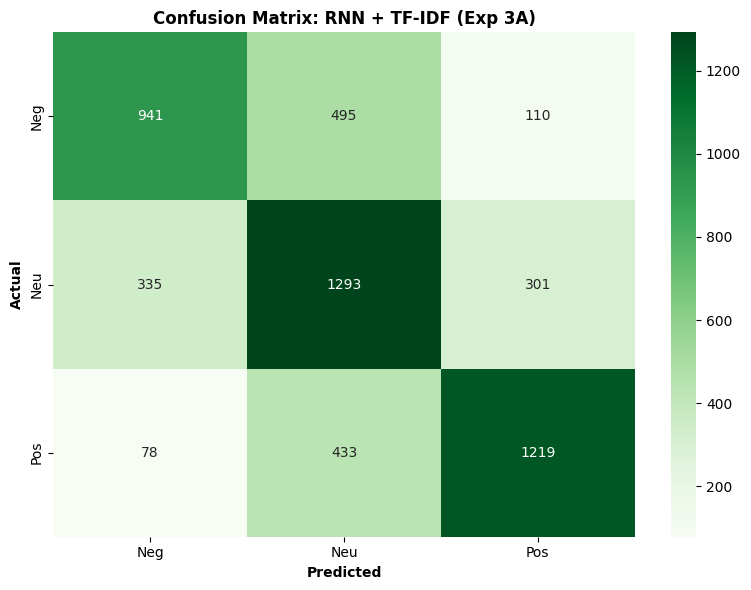

 Experiment 3A complete!


In [12]:
# CELL 11: TF-IDF EMBEDDING - EXPERIMENT 3A
# ============================================

from sklearn.feature_extraction.text import TfidfVectorizer

print("=" * 70)
print("EXPERIMENT 3A: RNN + TF-IDF")
print("=" * 70)

print("\n Generating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)

X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text_str']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_df['cleaned_text_str']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text_str']).toarray()

print(f"TF-IDF complete! Feature dimension: {X_train_tfidf.shape[1]}")

# Reshape for RNN
X_train_tfidf_reshaped = X_train_tfidf.reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
X_val_tfidf_reshaped = X_val_tfidf.reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])
X_test_tfidf_reshaped = X_test_tfidf.reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

def build_rnn_tfidf_model(input_dim, units=64, dropout=0.2, name="RNN_TFIDF"):
    """
    Build Simple RNN model for TF-IDF inputs
    """
    model = Sequential([
        SimpleRNN(units, input_shape=(1, input_dim), dropout=dropout, recurrent_dropout=dropout, name='rnn'),
        Dense(32, activation='relu', name='dense_1'),
        Dropout(0.5),
        Dense(3, activation='softmax', name='output')
    ], name=name)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_tfidf_exp1 = build_rnn_tfidf_model(X_train_tfidf.shape[1], units=64, dropout=0.2, name="RNN_TFIDF_Exp3A")

print("\nTraining RNN + TF-IDF (Experiment 3A)...")
history_tfidf_exp1 = model_tfidf_exp1.fit(
    X_train_tfidf_reshaped, y_train, epochs=15, batch_size=64,
    validation_data=(X_val_tfidf_reshaped, y_val), callbacks=[early_stop, reduce_lr], verbose=1
)

# Evaluate
y_pred_tfidf_exp1 = np.argmax(model_tfidf_exp1.predict(X_test_tfidf_reshaped, verbose=0), axis=1)
acc_tfidf_exp1 = accuracy_score(y_test, y_pred_tfidf_exp1)
f1_tfidf_exp1 = f1_score(y_test, y_pred_tfidf_exp1, average='weighted')
precision_tfidf_exp1 = precision_score(y_test, y_pred_tfidf_exp1, average='weighted')
recall_tfidf_exp1 = recall_score(y_test, y_pred_tfidf_exp1, average='weighted')

print("\n" + "=" * 70)
print("EXPERIMENT 3A RESULTS: RNN + TF-IDF")
print("=" * 70)
print(f"Test Accuracy:  {acc_tfidf_exp1:.4f}")
print(f"Test F1-Score:  {f1_tfidf_exp1:.4f}")
print(f"Test Precision: {precision_tfidf_exp1:.4f}")
print(f"Test Recall:    {recall_tfidf_exp1:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_tfidf_exp1,
                          target_names=['Negative', 'Neutral', 'Positive'], digits=4))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_tfidf_exp1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.title('Confusion Matrix: RNN + TF-IDF (Exp 3A)', fontweight='bold')
plt.tight_layout()
plt.show()

print(" Experiment 3A complete!")

In [ ]:
# CELL 12: TF-IDF EXPERIMENT 3B
# ============================================

print("\n" + "=" * 70)
print("EXPERIMENT 3B: RNN + TF-IDF ")
print("=" * 70)

model_tfidf_exp2 = build_rnn_tfidf_model(X_train_tfidf.shape[1], units=128, dropout=0.3, name="RNN_TFIDF_Exp3B")

print("\n Training...")
history_tfidf_exp2 = model_tfidf_exp2.fit(
    X_train_tfidf_reshaped, y_train, epochs=15, batch_size=64,
    validation_data=(X_val_tfidf_reshaped, y_val), callbacks=[early_stop, reduce_lr], verbose=1
)

# Evaluate
y_pred_tfidf_exp2 = np.argmax(model_tfidf_exp2.predict(X_test_tfidf_reshaped, verbose=0), axis=1)
acc_tfidf_exp2 = accuracy_score(y_test, y_pred_tfidf_exp2)
f1_tfidf_exp2 = f1_score(y_test, y_pred_tfidf_exp2, average='weighted')
precision_tfidf_exp2 = precision_score(y_test, y_pred_tfidf_exp2, average='weighted')
recall_tfidf_exp2 = recall_score(y_test, y_pred_tfidf_exp2, average='weighted')

print("\n" + "=" * 70)
print("EXPERIMENT 3B RESULTS")
print("=" * 70)
print(f"Test Accuracy:  {acc_tfidf_exp2:.4f}")
print(f"Test F1-Score:  {f1_tfidf_exp2:.4f}")
print(f" Improvement: {(acc_tfidf_exp2 - acc_tfidf_exp1) * 100:+.2f}% accuracy")
print(" Experiment 3B complete!")


EXPERIMENT 3B: RNN + TF-IDF 

 Training...
Epoch 1/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.4992 - loss: 0.9858 - val_accuracy: 0.6563 - val_loss: 0.7909 - learning_rate: 0.0010
Epoch 2/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6358 - loss: 0.8259 - val_accuracy: 0.6555 - val_loss: 0.7765 - learning_rate: 0.0010
Epoch 3/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6498 - loss: 0.7980 - val_accuracy: 0.6500 - val_loss: 0.7747 - learning_rate: 0.0010
Epoch 4/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6625 - loss: 0.7706 - val_accuracy: 0.6482 - val_loss: 0.7833 - learning_rate: 0.0010
Epoch 5/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6612 - loss: 0.7657 - val_accuracy: 0.6496 - val_loss: 0.7861 - learning_rate: 0.0010
Epoch 6/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6746 - loss: 0.7398 - val_accuracy: 0.6457 - val_loss: 0.7880 - learning_rate: 5.0000e-04

EXPERIMENT 3B RESULTS
Test Accur

In [ ]:
# CELL 13: COMPREHENSIVE COMPARISON TABLE 1 - ALL EXPERIMENTS
# ============================================

print("\n" + "=" * 80)
print("TABLE 1: COMPREHENSIVE RNN EXPERIMENTS COMPARISON")
print("=" * 80)

results_data = {
    'Experiment': [
        '1A: Word2Vec (64u, frozen)',
        '1B: Word2Vec (128u, trainable)',
        '2A: GloVe (64u, frozen)',
        '2B: GloVe (64u, trainable)',
        '3A: TF-IDF (64u)',
        '3B: TF-IDF (128u)'
    ],
    'Embedding': ['Word2Vec', 'Word2Vec', 'GloVe', 'GloVe', 'TF-IDF', 'TF-IDF'],
    'RNN Units': [64, 128, 64, 64, 64, 128],
    'Trainable': ['No', 'Yes', 'No', 'Yes', 'N/A', 'N/A'],
    'Accuracy': [
        acc_w2v_exp1, acc_w2v_exp2,
        acc_glove_exp1, acc_glove_exp2,
        acc_tfidf_exp1, acc_tfidf_exp2
    ],
    'F1-Score': [
        f1_w2v_exp1, f1_w2v_exp2,
        f1_glove_exp1, f1_glove_exp2,
        f1_tfidf_exp1, f1_tfidf_exp2
    ],
    'Precision': [
        precision_w2v_exp1, precision_w2v_exp2,
        precision_glove_exp1, precision_glove_exp2,
        precision_tfidf_exp1, precision_tfidf_exp2
    ],
    'Recall': [
        recall_w2v_exp1, recall_w2v_exp2,
        recall_glove_exp1, recall_glove_exp2,
        recall_tfidf_exp1, recall_tfidf_exp2
    ]
}

results_df = pd.DataFrame(results_data)
for col in ['Accuracy', 'F1-Score', 'Precision', 'Recall']:
    results_df[col] = results_df[col].apply(lambda x: f'{x:.4f}')

print("\n", results_df.to_string(index=False))
results_df.to_csv('rnn_experiments_results.csv', index=False)
print("\n Results saved to 'rnn_experiments_results.csv'")

# Best performers
results_df_numeric = results_df.copy()
for col in ['Accuracy', 'F1-Score', 'Precision', 'Recall']:
    results_df_numeric[col] = results_df_numeric[col].astype(float)

print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("=" * 80)
best_acc_idx = results_df_numeric['Accuracy'].idxmax()
print(f" Best Accuracy: {results_df.iloc[best_acc_idx]['Experiment']} ({results_df.iloc[best_acc_idx]['Accuracy']})")


TABLE 1: COMPREHENSIVE RNN EXPERIMENTS COMPARISON

                     Experiment Embedding  RNN Units Trainable Accuracy F1-Score Precision Recall
    1A: Word2Vec (64u, frozen)  Word2Vec         64        No   0.3706   0.2004    0.1373 0.3706
1B: Word2Vec (128u, trainable)  Word2Vec        128       Yes   0.3706   0.2004    0.1373 0.3706
       2A: GloVe (64u, frozen)     GloVe         64        No   0.3706   0.2004    0.1373 0.3706
    2B: GloVe (64u, trainable)     GloVe         64       Yes   0.3706   0.2004    0.1373 0.3706
              3A: TF-IDF (64u)    TF-IDF         64       N/A   0.6555   0.6566    0.6632 0.6555
             3B: TF-IDF (128u)    TF-IDF        128       N/A   0.6565   0.6577    0.6616 0.6565

 Results saved to 'rnn_experiments_results.csv'

KEY FINDINGS:
 Best Accuracy: 3B: TF-IDF (128u) (0.6565)



TABLE 2: EMBEDDING TYPE COMPARISON (BEST PER EMBEDDING)

       Embedding Type Best Experiment Best Accuracy Best F1-Score
Word2Vec (Skip-gram)          Exp 1A        0.3706        0.2004
               GloVe          Exp 2A        0.3706        0.2004
              TF-IDF          Exp 3B        0.6565        0.6579

 Saved to 'rnn_embedding_comparison.csv'

RANKING (by Accuracy):
 1. TF-IDF: 0.6565 accuracy
 2. Word2Vec (Skip-gram): 0.3706 accuracy
 3. GloVe: 0.3706 accuracy


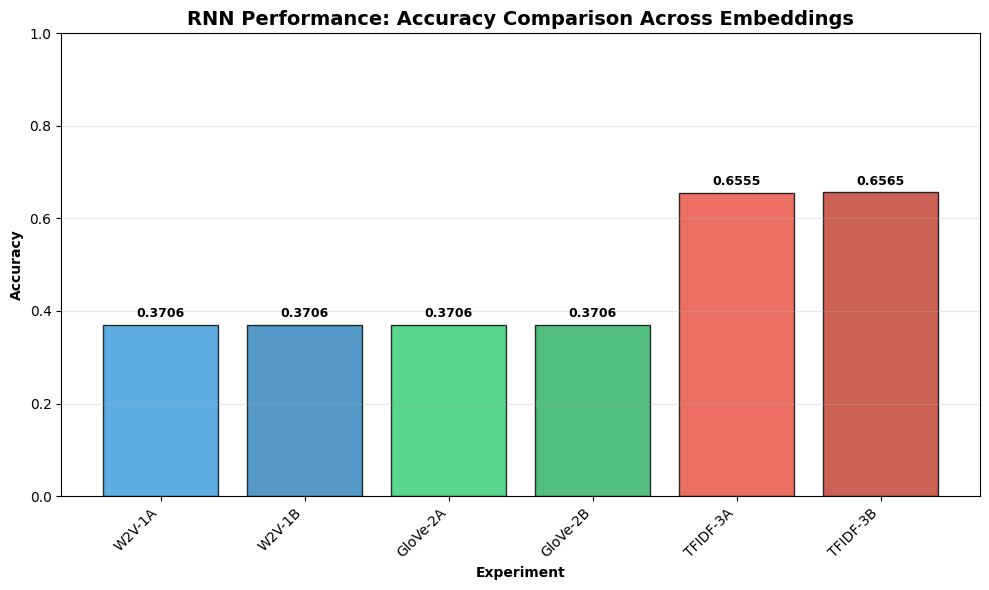

 Chart saved as 'rnn_embedding_comparison.png'


In [ ]:
# CELL 14: COMPARISON TABLE 2 - EMBEDDING TYPE
# ============================================

print("\n" + "=" * 80)
print("TABLE 2: EMBEDDING TYPE COMPARISON (BEST PER EMBEDDING)")
print("=" * 80)

embedding_summary = {
    'Embedding Type': ['Word2Vec (Skip-gram)', 'GloVe', 'TF-IDF'],
    'Best Experiment': [
        f"Exp 1{'B' if acc_w2v_exp2 > acc_w2v_exp1 else 'A'}",
        f"Exp 2{'B' if acc_glove_exp2 > acc_glove_exp1 else 'A'}",
        f"Exp 3{'B' if acc_tfidf_exp2 > acc_tfidf_exp1 else 'A'}"
    ],
    'Best Accuracy': [
        max(acc_w2v_exp1, acc_w2v_exp2),
        max(acc_glove_exp1, acc_glove_exp2),
        max(acc_tfidf_exp1, acc_tfidf_exp2)
    ],
    'Best F1-Score': [
        max(f1_w2v_exp1, f1_w2v_exp2),
        max(f1_glove_exp1, f1_glove_exp2),
        max(f1_tfidf_exp1, f1_tfidf_exp2)
    ]
}

embedding_df = pd.DataFrame(embedding_summary)
for col in ['Best Accuracy', 'Best F1-Score']:
    embedding_df[col] = embedding_df[col].apply(lambda x: f'{x:.4f}')

print("\n", embedding_df.to_string(index=False))
embedding_df.to_csv('rnn_embedding_comparison.csv', index=False)
print("\n Saved to 'rnn_embedding_comparison.csv'")

# Ranking
embedding_df_sort = embedding_df.copy()
embedding_df_sort['Best Accuracy'] = embedding_df_sort['Best Accuracy'].astype(float)
embedding_df_sort = embedding_df_sort.sort_values('Best Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "=" * 80)
print("RANKING (by Accuracy):")
print("=" * 80)
for idx, row in embedding_df_sort.iterrows():
    medal = ['', '', ''][idx] if idx < 3 else '  '
    print(f"{medal} {idx+1}. {row['Embedding Type']}: {row['Best Accuracy']} accuracy")

# Visualization
plt.figure(figsize=(10, 6))
experiments = ['W2V-1A', 'W2V-1B', 'GloVe-2A', 'GloVe-2B', 'TFIDF-3A', 'TFIDF-3B']
accuracies = [acc_w2v_exp1, acc_w2v_exp2, acc_glove_exp1, acc_glove_exp2, acc_tfidf_exp1, acc_tfidf_exp2]
colors = ['#3498db', '#2980b9', '#2ecc71', '#27ae60', '#e74c3c', '#c0392b']

bars = plt.bar(experiments, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.title('RNN Performance: Accuracy Comparison Across Embeddings', fontsize=14, fontweight='bold')
plt.xlabel('Experiment', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('rnn_embedding_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Chart saved as 'rnn_embedding_comparison.png'")